<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-08 12:29:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2020-11-08 12:29:01 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male

In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   45  High School or Below    male  
1 2016-10-07   33              Bechalor  female  
2 2016-09-22   27               college    male  
3 2016-10-08   28               college  female  
4 2016-10-08   29               college    male

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

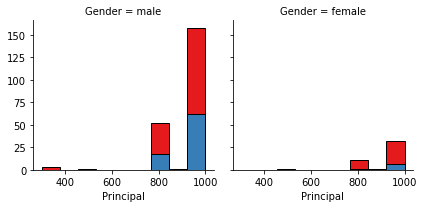

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

plt.show()

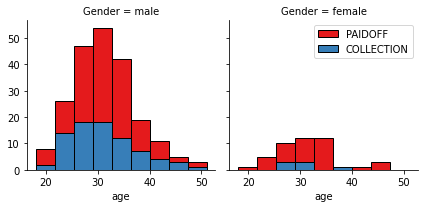

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

In [10]:
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  
0 2016-10-07   45  High School or Below    male  
1 2016-10-07   33              Bechalor  female  
2 2016-09-22   27               college    male  
3 2016-10-08   28               college  female  
4 2016-10-08   29               college    male

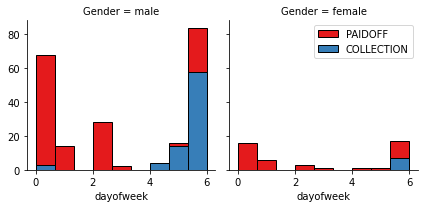

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below    male          3        0  
1 2016-10-07   33              Bechalor  female          3        0  
2 2016-09-22   27               college    male          3        0  
3 2016-10-08   28               college  female          4        1  
4 2016-10-08   29               college    male          4        1

## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   45  High School or Below       0          3        0  
1 2016-10-07   33              Bechalor       1          3        0  
2 2016-09-22   27               college       0          3        0  
3 2016-10-08   28               college       1          4        1  
4 2016-10-08   29               college       0          4        1

## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

Principal  terms  age  Gender             education
0       1000     30   45       0  High School or Below
1       1000     30   33       1              Bechalor
2       1000     15   27       0               college
3       1000     30   28       1               college
4       1000     30   29       0               college

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [138]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1

### Feature selection

Lets defind feature sets, X:

In [131]:
X = Feature
X[0:5]
X.shape

(346, 8)

What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [20]:
from sklearn import preprocessing
le_y = preprocessing.LabelEncoder()
le_y.fit(y)
le_y = le_y.transform(y)



In [132]:
le_y.shape

(346,)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [133]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X.shape

(346, 8)

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [23]:
def hyperparameter(X_len, accuracy_list, hyperparameter = "Hyperparameter"):
    x_value = np.linspace(1.0, X_len, X_len)
    plt.plot(x_value, accuracy_list)
    plt.xlabel(f"{hyperparameter}")
    plt.ylabel("accuracy_score")
    print(f"Max accuracy:{np.max(accuracy_list)}")
    print(f"Best {hyperparameter}: {np.argmax(accuracy_list)}")
    return np.argmax(accuracy_list), np.max(accuracy_list)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
accuracy = []
length = int(np.round(np.sqrt(le_y.shape[0])))+1
# for i in range(length):
for i in range(length):
    X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.2, random_state = i)
    KNN = KNeighborsClassifier(n_neighbors = i+1, metric = "euclidean").fit(X_train, y_train)
    score = metrics.accuracy_score(y_test, KNN.predict(X_test))
    accuracy.append(score)

Max accuracy:0.8428571428571429
Best k_value: 16


(16, 0.8428571428571429)

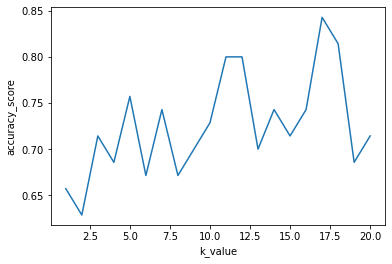

In [65]:
hyperparameter(length, accuracy, "k_value")

Max accuracy:0.8
Best random state: 9


(9, 0.8)

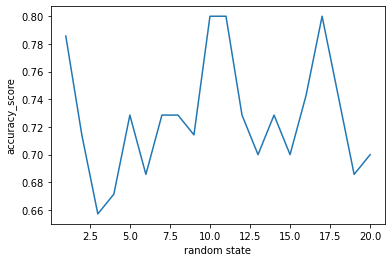

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
accuracy = []
length = int(np.round(np.sqrt(le_y.shape[0])))+1
for i in range(length):
    X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.2, random_state = i)
    KNN = KNeighborsClassifier(n_neighbors = 16, metric = "euclidean").fit(X_train, y_train)
    score = metrics.accuracy_score(y_test, KNN.predict(X_test))
    accuracy.append(score)
hyperparameter(length, accuracy, "random state")

In [78]:
KNN = KNeighborsClassifier(n_neighbors = 16, metric = "euclidean").fit(X_train, y_train)

# Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
#X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.2, random_state = 4)

DT = DecisionTreeClassifier(criterion = "entropy", max_depth = 6 ).fit(X_train, y_train)
score = metrics.accuracy_score(DT.predict(X_test), y_test)
score

0.7714285714285715

# Support Vector Machine

Max accuracy:0.8285714285714286
Best kernel: 0
best kernel: linear


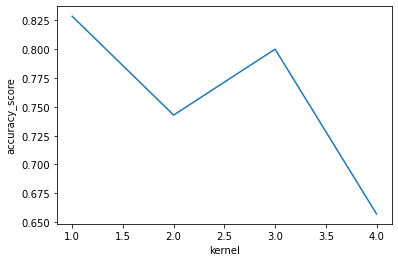

In [67]:
from sklearn import svm
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
SVM_acc = []
for c, i in enumerate(kernel):
    X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.2, random_state = c)
    SVM = svm.SVC(kernel= i).fit(X_train, y_train)
    score = metrics.accuracy_score(SVM.predict(X_test), y_test)
    SVM_acc.append(score)
index, _ = hyperparameter(len(kernel), SVM_acc, "kernel")
print(f"best kernel: {kernel[index]}")

In [68]:
SVM = svm.SVC(kernel= "linear").fit(X_train, y_train)

# Logistic Regression

In [162]:
from sklearn.linear_model import LogisticRegression
Log_acc = []
solver = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

cross_validation = [1,2,3,4,5]
for i, c in zip(solver, cross_validation):
    X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.2, random_state = 4)
    LR = LogisticRegression(C = 0.01, solver = i).fit(X_train, y_train)
    score = metrics.accuracy_score(LR.predict(X_test), y_test)
    Log_acc.append(score)

Max accuracy:0.7857142857142857
Best Solver: 1
newton-cg


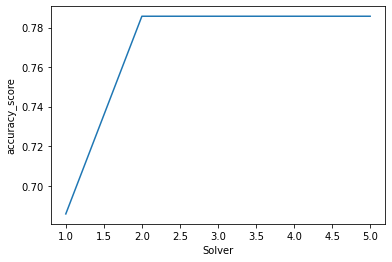

In [163]:
ind, _ = hyperparameter(len(solver), Log_acc, "Solver" )
print(solver[ind])

In [173]:
Log_acc = []
c_value = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

cross_validation = [1,2,3,4,5,6,7]
for i, c in zip(c_value, cross_validation):
    X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.2, random_state = 4)
    LR = LogisticRegression(C = i, solver = "lbfgs").fit(X_train, y_train)
    score = metrics.accuracy_score(LR.predict(X_test), y_test)
    Log_acc.append(score)

Max accuracy:0.7857142857142857
Best C_value: 0
best C_value: 0.001


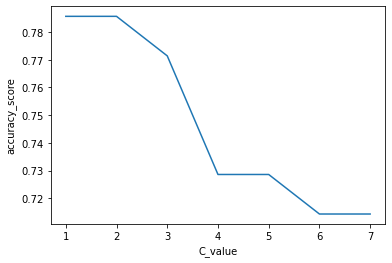

In [175]:
ind, _ = hyperparameter(len(c_value), Log_acc, "C_value" )
print("best C_value:", c_value[ind])

In [206]:
LR = LogisticRegression(C = 0.001, solver = "liblinear").fit(X_train, y_train)

In [237]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size = 0.2, random_state = c)
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selecti

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.7718253968253967


In [238]:
LR = LogisticRegression(C = 0.001, penalty = "l2").fit(X_train, y_train)

In [239]:
print("Log loss:", log_loss(test_le_y, LR.predict(testX)))
print(metrics.accuracy_score(test_le_y, LR.predict(testX)))

Log loss: 8.95470488690319
0.7407407407407407


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-11-08 12:29:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-11-08 12:29:05 (78.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [89]:
testdf.

Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           1             1     PAIDOFF       1000     30     2016-09-08   
1           5             5     PAIDOFF        300      7     2016-09-09   
2          21            21     PAIDOFF       1000     30     2016-09-10   
3          24            24     PAIDOFF       1000     30     2016-09-10   
4          35            35     PAIDOFF        800     15     2016-09-11   

    due_date  age             education  Gender  dayofweek  weekend  
0 2016-10-07   50              Bechalor       1          3        0  
1 2016-09-15   35       Master or Above       0          4        1  
2 2016-10-09   43  High School or Below       1          5        1  
3 2016-10-09   26               college       0          5        1  
4 2016-09-25   29              Bechalor       0          6        1

In [124]:
testdf = pd.read_csv('loan_test.csv')
# testdf.dropna(axis=0, inplace = True)

testdf['due_date'] = pd.to_datetime(testdf['due_date'])
testdf['effective_date'] = pd.to_datetime(testdf['effective_date'])
testdf['dayofweek'] = testdf['effective_date'].dt.dayofweek
testdf['weekend'] = testdf['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
testdf['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
testFeature = testdf[['Principal','terms','age','Gender','weekend']]
testFeature = pd.concat([testFeature, pd.get_dummies(testdf['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)
testFeature = pd.concat([testFeature, testdf["loan_status"]], axis=1)
testFeature.dropna(axis=0, inplace = True)
testFeature
testFeature.shape
testdf.shape

(54, 12)

In [140]:
testFeature.head()

Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   50       1        0         1                     0   
1        300      7   35       0        1         0                     0   
2       1000     30   43       1        1         0                     1   
3       1000     30   26       0        1         0                     0   
4        800     15   29       0        1         1                     0   

   college loan_status  
0        0     PAIDOFF  
1        0     PAIDOFF  
2        0     PAIDOFF  
3        1     PAIDOFF  
4        0     PAIDOFF

In [142]:
testX = testFeature[['Principal','terms','age','Gender','weekend',"Bechalor", "High School or Below", "college"]]
testX = preprocessing.StandardScaler().fit(testX).transform(testX)
testX.shape

(54, 8)

In [143]:
testX

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677],
       [-1.24479571, -0.78854628,  0.19650211, -0.50578054,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588, -0.78854628, -1.31937134, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [ 0.49362588,  0.92844966,  0.02807173, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677],
       [-0.66532184, -0.78854628

In [145]:
testy = testFeature['loan_status'].values
test_le_y = preprocessing.LabelEncoder()
test_le_y.fit(testy)
test_le_y = test_le_y.transform(testy)

# Jaccard

In [158]:
print("KNN:", jaccard_score(KNN.predict(testX), test_le_y))
print("Decision Tree:", jaccard_score(DT.predict(testX), test_le_y))
print("SVM:", jaccard_score(SVM.predict(testX), test_le_y))
print("Log regression:", jaccard_score(LR.predict(testX), test_le_y))

KNN: 0.7307692307692307
Decision Tree: 0.7115384615384616
SVM: 0.7037037037037037
Log regression: 0.7407407407407407


# F1

In [159]:
print("KNN:", f1_score(KNN.predict(testX), test_le_y, average = "weighted"))
print("Decision Tree:", f1_score(DT.predict(testX), test_le_y, average = "weighted"))
print("SVM:", f1_score(SVM.predict(testX), test_le_y, average = "weighted"))
print("Log regression:", f1_score(LR.predict(testX), test_le_y, average = "weighted"))

KNN: 0.7983539094650205
Decision Tree: 0.773966752086208
SVM: 0.7954911433172304
Log regression: 0.851063829787234


# Log loss

In [240]:
print("Log loss:", log_loss(test_le_y, LR.predict(testX)))

Log loss: 8.95470488690319


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.73    | 0.79     | NA      |
| Decision Tree      | 0.71    | 0.77     | NA      |
| SVM                | 0.70    | 0.79     | NA      |
| LogisticRegression | 0.74    | 0.85     | 8.95       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>